# Kernel PCA
1. Pick a kernel(polynomial, sigmoid, rbf)
2. Construct the normalized kernel matrix of the data(dimension: m by m)
3. Solve an eigenvalue problem
4. For any data point(new or old), we can represent it as linear combination form

PCA로는 선형으로 구분하기 어려운 데이터를 사용한다.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

np.random.seed(0)

X, y = make_circles(n_samples=400, factor=.3, noise=.05)

scikit learn에 있는 PCA와 Kernel PCA를 사용하여 data를 transform한다.

In [12]:
kpca = KernelPCA(n_components=2, kernel="rbf", gamma=10)
X_kpca = kpca.fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X)

직접 구현한 Kernel PCA를 정의하고 이를 이용하여 data를 transform한다.

In [13]:
#define kernel matrix
def kernel_matrix(x, kernel=None, d=3, sigma=None, C=1.):
    
    n = x.shape[0]
    if sigma is None:
        sigma = 1./n
    
    xxt = x.dot(x.T)
    if kernel == 'polynomial':
        return (C + xxt)**d
    elif kernel == 'sigmoid':
        return np.tanh(sigma*xxt + C)
    elif kernel == 'rbf':
        A = x.dot(x.T)
        B = np.repeat(np.diag(xxt), n).reshape(n, n)
        return np.exp(-(B.T - 2*A + B)/(2*sigma**2))
    else:
        return xxt

K = kernel_matrix(X, kernel='rbf', sigma=1/np.sqrt(20))
print(K.shape)
print(K)

#solve eigenvalue decomposition for centered kernel
n = K.shape[0]
one_mat = np.repeat(1/n, n**2).reshape(n, n)
gram = K - one_mat.dot(K) - K.dot(one_mat) + one_mat.dot(K).dot(one_mat)
eigen_vals, eigen_vecs = np.linalg.eigh(gram)

eigen_pairs = [(eigen_vals[i], eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key = lambda x: x[0], reverse=True)

#transform data
n_components = 2

transformed_data = []
for j in range(n):
    loc = np.zeros(n_components)
    for k in range(n_components):
        inner_prod_sum = 0.
        for i in range(n):
            inner_prod_sum += eigen_pairs[k][1][i] * gram[j,i]
        loc[k] = inner_prod_sum/np.sqrt(eigen_pairs[k][0])
    transformed_data.append(loc)    
    
transformed_data = np.array(transformed_data)

(400, 400)
[[  1.00000000e+00   1.14001545e-03   1.29642562e-02 ...,   4.98075056e-02
    3.66619299e-18   2.56508190e-06]
 [  1.14001545e-03   1.00000000e+00   6.05818585e-01 ...,   1.40963995e-03
    6.71072925e-07   1.23038222e-05]
 [  1.29642562e-02   6.05818585e-01   1.00000000e+00 ...,   1.99638926e-03
    3.18195347e-09   3.61176357e-04]
 ..., 
 [  4.98075056e-02   1.40963995e-03   1.99638926e-03 ...,   1.00000000e+00
    6.08584603e-15   2.83718000e-11]
 [  3.66619299e-18   6.71072925e-07   3.18195347e-09 ...,   6.08584603e-15
    1.00000000e+00   2.66544361e-17]
 [  2.56508190e-06   1.23038222e-05   3.61176357e-04 ...,   2.83718000e-11
    2.66544361e-17   1.00000000e+00]]


Original space에서 데이터 형태와 PCA로 사영시킨 데이터 형태, KPCA로 사영시킨 데이터 형태를 시각화하여 비교한다.
KPCA는 scikit learn의 패키지를 사용한 결과와 구현한 코드를 이용한 결과를 비교하였다. 

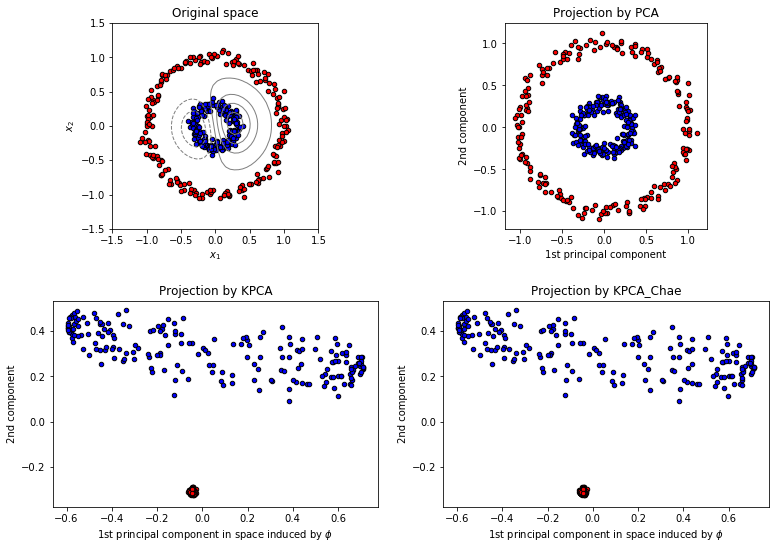

In [14]:
# Plot results
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(X[reds, 0], X[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

X1, X2 = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
# projection on the first principal component (in the phi space)
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(X_pca[reds, 0], X_pca[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_pca[blues, 0], X_pca[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")

plt.subplot(2, 2, 3, aspect='equal')
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by KPCA")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplot(2, 2, 4, aspect='equal')
plt.scatter(transformed_data[reds, 0], transformed_data[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(transformed_data[blues, 0], transformed_data[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by KPCA_Chae")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplots_adjust(0.02, 0.10, 1.35, 0.94, 0.04, 0.35)

plt.show()

rbf 외에 다른 커널을 적용했을 때는 어떤지 확인해본다.

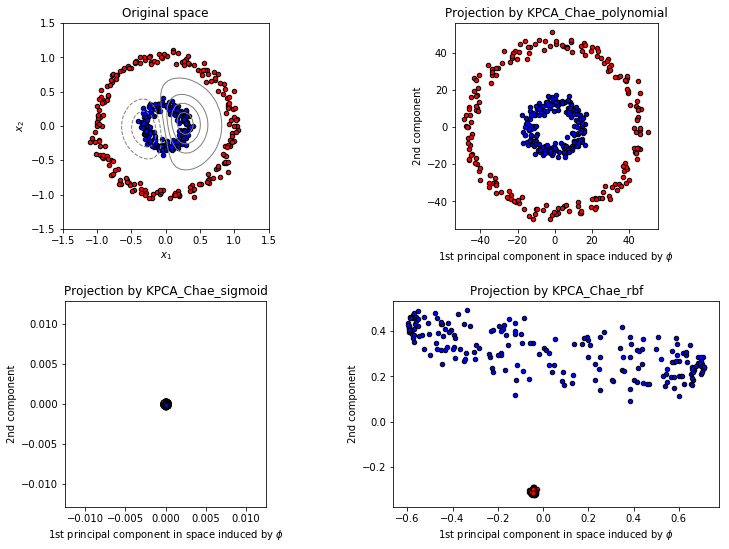

In [16]:
#comparison by kernels
def experiment(K):
    #solve eigenvalue decomposition for centered kernel
    n = K.shape[0]
    one_mat = np.repeat(1/n, n**2).reshape(n, n)
    gram = K - one_mat.dot(K) - K.dot(one_mat) + one_mat.dot(K).dot(one_mat)
    eigen_vals, eigen_vecs = np.linalg.eigh(gram)
    
    eigen_pairs = [(eigen_vals[i], eigen_vecs[:,i]) for i in range(len(eigen_vals))]
    eigen_pairs.sort(key = lambda x: x[0], reverse=True)
    
    #transform data
    n_components = 2
    
    transformed_data = []
    for j in range(n):
        loc = np.zeros(n_components)
        for k in range(n_components):
            inner_prod_sum = 0.
            for i in range(n):
                inner_prod_sum += eigen_pairs[k][1][i] * gram[j,i]
            loc[k] = inner_prod_sum/np.sqrt(eigen_pairs[k][0])
        transformed_data.append(loc)    
        
    return np.array(transformed_data)


results = []
for kernel_type in ['polynomial', 'sigmoid', 'rbf']:
    K = kernel_matrix(X, kernel= kernel_type, sigma=1/np.sqrt(20), d=4, C=8)    
    results.append(experiment(K))

trans_poly = results[0]
trans_sig = results[1]
trans_rbf = results[2]

# Plot kpca results by kernels
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(X[reds, 0], X[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

X1, X2 = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
# projection on the first principal component (in the phi space)
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(trans_poly[reds, 0], trans_poly[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(trans_poly[blues, 0], trans_poly[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by KPCA_Chae_polynomial")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplot(2, 2, 3, aspect='equal')
plt.scatter(trans_sig[reds, 0], trans_sig[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(trans_sig[blues, 0], trans_sig[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by KPCA_Chae_sigmoid")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplot(2, 2, 4, aspect='equal')
plt.scatter(trans_rbf[reds, 0], trans_rbf[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(trans_rbf[blues, 0], trans_rbf[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by KPCA_Chae_rbf")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplots_adjust(0.02, 0.10, 1.35, 0.94, 0.04, 0.35)

plt.show()
